# Example usage of ArCO-GP

This notebook illustrates Bayesian causal inference with ArCO-GP, i.e., using ArCO for approximate causal order inference with limited parent set size
and a GP mechanism model.


In [3]:

# imports
%reload_ext autoreload
%autoreload 2
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from src.abci_arco_gp import ABCIArCOGP as ABCI
from src.config import ABCIArCOGPConfig
from src.environments.experiment import gather_data
from src.environments.generic_environments import *
from src.mechanism_models.mechanisms import get_mechanism_key


First, we generate a ground truth environment/SCM.


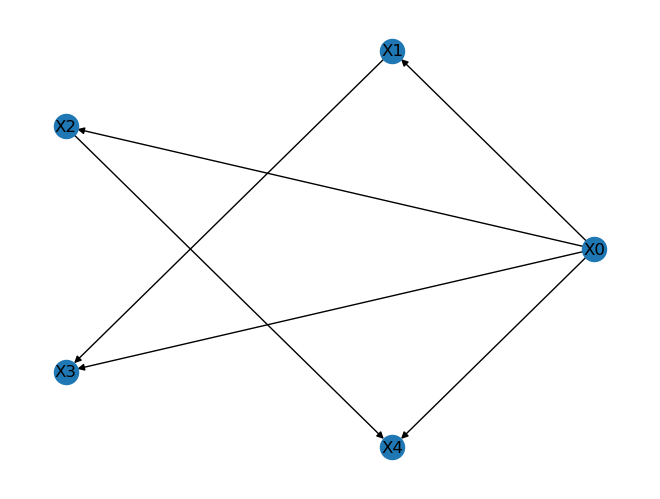

In [4]:
# init environment

# specify the number of nodes 
num_nodes = 5
env_cfg = EnvironmentConfig()
env_cfg.num_observational_train_samples = 30
env_cfg.num_observational_test_samples = 20
env_cfg.generate_static_intr_dataset = True
env_cfg.num_interventional_train_samples = 10
env_cfg.num_train_interventions = 5
env_cfg.num_interventional_test_samples = 7
env_cfg.num_test_interventions = 3
env_cfg.linear = False
env_cfg.normalise_data = True

env = BarabasiAlbert(num_nodes, env_cfg)

# plot true graph
nx.draw(env.graph, nx.circular_layout(env.graph), labels=dict(zip(env.graph.nodes, env.graph.nodes)))


Here, we create an ABCI instance with the desired experimental design policy.

In [5]:

cfg = ABCIArCOGPConfig()
cfg.policy = 'static-obs-dataset'
cfg.max_ps_size = 2
cfg.num_arco_steps = 100
abci = ABCI(env, cfg)



We can now run a number of ABCI loops.

Load static observational training data from environment...
Optimising causal order model...
Updating 50 GP's hyperparams on 1 experiments...
Stopping GP parameter optimization after 12 steps ...
Updated 10/50 GPs... 
Stopping GP parameter optimization after 12 steps ...
Updated 20/50 GPs... 
Stopping GP parameter optimization after 12 steps ...
Updated 30/50 GPs... 
Stopping GP parameter optimization after 12 steps ...
Updated 40/50 GPs... 
Stopping GP parameter optimization after 14 steps ...
Updated 50/50 GPs... 
Step 1 of 100, com loss is 7.502019882202148
Step 21 of 100, com loss is 2.5921292304992676
Step 41 of 100, com loss is 2.6970467567443848
Step 61 of 100, com loss is 3.0827078819274902
Stopping com optimization after 62 steps ...
There are currently 50 unique GPs in our model.
Creating model checkpoint and logging stats...
Computing structure metrics (AUROC, AUPRC, SHD,...)
Computing AID metrics...
Computing distributional metrics on interventional test data...
Computing m

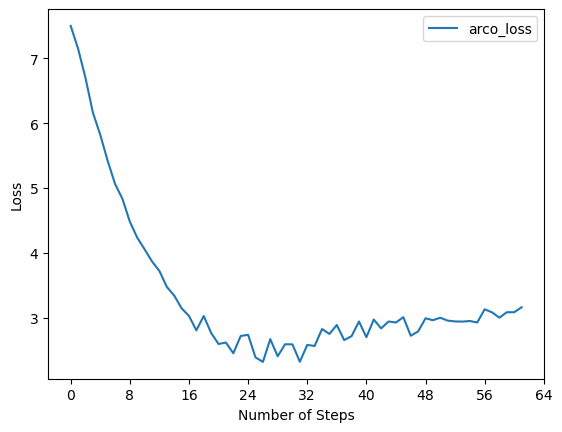

In [6]:

abci.run()

# plot loss over experiments
ax = plt.figure().gca()
plt.plot(abci.stats['arco_loss'], label='arco_loss')
plt.xlabel('Number of Steps')
plt.ylabel('Loss')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()

Print structure learning stats.

In [7]:
# optionally: recompute the structure learning stats
# abci.stats.clear()
# abci.compute_stats()

print()
print(f"ESHD {abci.stats['eshd']} vs. ESHD CPDAG {abci.stats['eshd_cpdag']}")
print(f"True Num E {env.graph.number_of_edges()} vs. E-NUM Edges{abci.stats['enum_edges']}")
print(f"A-AID {abci.stats['aaid']}   vs. A-AID cpdag {abci.stats['aaid_cpdag']}")
print(f"P-AID {abci.stats['paid']}   vs. P-AID cpdag {abci.stats['paid_cpdag']}")
print(f"OSET-AID {abci.stats['oset_aid']} vs. OSET-AID cpdag {abci.stats['oset_aid_cpdag']} ")
print(f"ORDER-AID {abci.stats['order_aid']} ")
print()
print(f"F1 {abci.stats['ef1']}     vs. F1 cpdag {abci.stats['ef1_cpdag']}")
print(f"TPR {abci.stats['etpr']} vs. TPR cpdag {abci.stats['etpr_cpdag']}")
print(f"TNR {abci.stats['etnr']} vs. TNR cpdag {abci.stats['etnr_cpdag']}")
print(f"FNR {abci.stats['efnr']} vs. FNR cpdag {abci.stats['efnr_cpdag']}")
print(f"FPR {abci.stats['efpr']} vs. FPR cpdag {abci.stats['efpr_cpdag']}")
print(f"AUROC {abci.stats['auroc']}  vs. AUROC CPDAG {abci.stats['auroc_cpdag']}")
print(f"AUPRC {abci.stats['auprc']}  vs. AUPRC CPDAG {abci.stats['auprc_cpdag']}")
print()



ESHD [tensor(2.5001)] vs. ESHD CPDAG [tensor(2.5001)]
True Num E 6 vs. E-NUM Edges[tensor(5.0837)]
A-AID [tensor(0.0257)]   vs. A-AID cpdag [tensor(0.0074)]
P-AID [tensor(0.1965)]   vs. P-AID cpdag [tensor(0.0074)]
OSET-AID [tensor(0.0855)] vs. OSET-AID cpdag [tensor(0.0074)] 
ORDER-AID [tensor(0.)] 

F1 [tensor(0.7744)]     vs. F1 cpdag [tensor(0.7744)]
TPR [tensor(0.7153)] vs. TPR cpdag [tensor(0.7153)]
TNR [tensor(0.9434)] vs. TNR cpdag [tensor(0.9010)]
FNR [tensor(0.2847)] vs. FNR cpdag [tensor(0.2847)]
FPR [tensor(0.0566)] vs. FPR cpdag [tensor(0.0990)]
AUROC [tensor(0.9524)]  vs. AUROC CPDAG [tensor(0.9167)]
AUPRC [tensor(0.9104)]  vs. AUPRC CPDAG [tensor(0.9104)]



Finally, we can have a look at the learned vs. true mechanisms. Here, we compare univariate mechanisms.

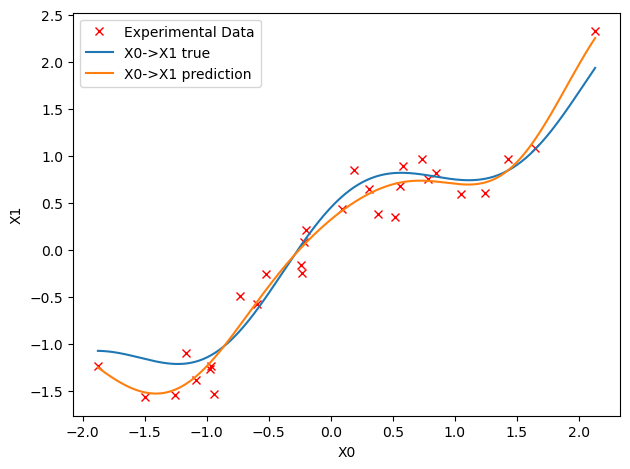

In [8]:
# setup
parent = 'X0'
target = 'X1'  # target node
num_points = 500

# compute true mechanism values
xdata, ydata = gather_data(abci.experiments, target, parents=[parent])
xrange = torch.linspace(xdata.min(), xdata.max(), num_points).unsqueeze(1)
ytrue = env.apply_mechanism(xrange, get_mechanism_key(target, [parent])).detach()

# compute predicted mechanism values
ypred = abci.mechanism_model.apply_mechanism(xrange.expand(-1, env.num_nodes),
                                             get_mechanism_key(target, [parent])).detach()

plt.figure()
plt.plot(xdata, ydata, 'rx', label='Experimental Data')
plt.plot(xrange, ytrue, label=f'{parent}->{target} true')
plt.plot(xrange, ypred, label=f'{parent}->{target} prediction')
plt.xlabel(parent)
plt.ylabel(target)
plt.legend()
plt.tight_layout()



Here, we compare bi-variate mechanisms.


Function values for X3 in range [(-2.5305070877075195, 2.8019933700561523)].


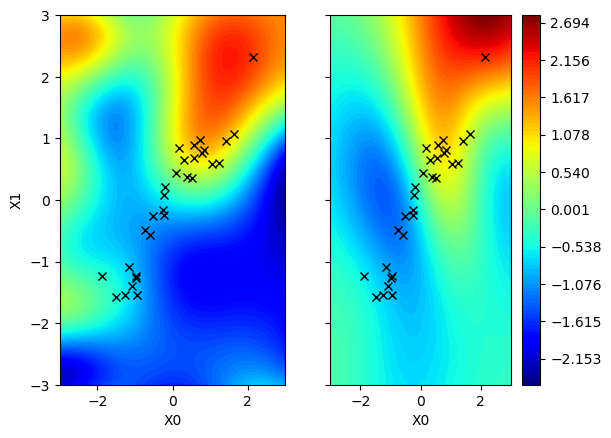

In [10]:
# plotting a bivariate mechanism
parents = ['X0', 'X1']
target = 'X3'
num_points = 100

# create meshgrid and compute true mechanism values
range_min = range_max = 3.
xrange = torch.linspace(-range_min, range_max, num_points)
yrange = torch.linspace(-range_min, range_max, num_points)
xgrid, ygrid = torch.meshgrid(xrange, yrange, indexing='ij')
inputs = torch.stack((xgrid, ygrid), dim=2).view(-1, 2)
ztrue = env.apply_mechanism(inputs, get_mechanism_key(target, parents)).detach().view(num_points, num_points).numpy()

# compute predicted mechanism values
tmp = torch.empty(num_points ** 2, env.num_nodes)
tmp[:, env.node_labels.index(parents[0])] = inputs[:, 0]
tmp[:, env.node_labels.index(parents[1])] = inputs[:, 1]
zpred = abci.mechanism_model.apply_mechanism(tmp, get_mechanism_key(target, parents))
zpred = zpred.cpu().detach().view(num_points, num_points).numpy()

zmin = min(ztrue.min().item(), zpred.min().item())
zmax = max(ztrue.max().item(), zpred.max().item())
levels = torch.linspace(zmin, zmax, 100).cpu().numpy()
print(f'Function values for {target} in range [{zmin, zmax}].')

# plot mechanisms
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
cp1 = axes[0].contourf(xgrid.cpu(), ygrid.cpu(), ztrue, cmap=plt.get_cmap('jet'), levels=levels, vmin=zmin, vmax=zmax,
                       antialiased=False)
cp2 = axes[1].contourf(xgrid.cpu(), ygrid.cpu(), zpred, cmap=plt.get_cmap('jet'), levels=levels, vmin=zmin, vmax=zmax,
                       antialiased=False)

sample_inputs, sample_targets = gather_data(abci.experiments, target, parents=parents)

axes[0].plot(sample_inputs[:, 0].cpu(), sample_inputs[:, 1].cpu(), 'kx')
axes[1].plot(sample_inputs[:, 0].cpu(), sample_inputs[:, 1].cpu(), 'kx')
axes[0].set_xlabel(parents[0])
axes[0].set_ylabel(parents[1])
ax.set_xlim([-range_min, range_max])
ax.set_ylim([-range_min, range_max])
axes[1].set_xlabel(parents[0])
_ = fig.colorbar(cp2)
